# Unsupervised Learning With KNN and PCA

Tram Duong
<br>October 19, 2020

### Part 1: EDA and FE 
- Data Exploration
- Data Cleaning
- Feature Engineerings

In [1]:
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from scipy import stats
from sklearn.preprocessing import StandardScaler
import pyod
# Import all models 
from pyod.models.knn import KNN
from pyod.models.pca import PCA
from pyod.utils.utility import standardizer
from pyod.models.combination import aom, moa, average, maximization

C:\Users\tramh\.conda\envs\Anomaly\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# read data 
payment_data = pd.read_csv("/data/inpatientCharges.csv")

A few things I noticed from the data overview:
   - Payments should be in numeric/float format to do statistics 
   - Zipcode column should be in character/object format
   - Provider ID should be in int format

In [3]:
payment_data.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


In [4]:
payment_data.describe()

,Provider Id,Provider Zip Code,Total Discharges
count,163065.000000,163065.000000,163065.000000
mean,255569.865428,47938.121908,42.776304
std,151563.671767,27854.323080,51.104042
min,10001.000000,1040.000000,11.000000
25%,110092.000000,27261.000000,17.000000
50%,250007.000000,44309.000000,27.000000
75%,380075.000000,72901.000000,49.000000
max,670077.000000,99835.000000,3383.000000


In [5]:
payment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   DRG Definition                        163065 non-null  object
 1   Provider Id                           163065 non-null  int64 
 2   Provider Name                         163065 non-null  object
 3   Provider Street Address               163065 non-null  object
 4   Provider City                         163065 non-null  object
 5   Provider State                        163065 non-null  object
 6   Provider Zip Code                     163065 non-null  int64 
 7   Hospital Referral Region Description  163065 non-null  object
 8    Total Discharges                     163065 non-null  int64 
 9    Average Covered Charges              163065 non-null  object
 10   Average Total Payments               163065 non-null  object
 11  Average Medic

According to the link: https://data.cms.gov/Medicare-Inpatient/National-Summary-of-Inpatient-Charge-Data-by-Medic/efwk-h4x3, the dataset description is below:

**DRG Definition** : Classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay.

**Total Discharges** : The number of discharges billed by all providers for inpatient hospital services.

**Average Covered Charges** : The average charge of all provider's services covered by Medicare for discharges in the DRG. These will vary from hospital to hospital because of differences in hospital charge structures.

**Average Total Payment**: The average total payments to all providers for the DRG including the MS-DRG amount, teaching, disproportionate share, capital, and outlier payments for all cases. Also included in average total payments are co-payment and deductible amounts that the patient is responsible for and any additional payments by third parties for coordination of benefits.

**Average Medicare Payment**: The average amount that Medicare pays to the provider for Medicare's share of the MS-DRG. Medicare payment amounts include the MS-DRG amount, teaching, disproportionate share, capital, and outlier payments for all cases. Medicare payments DO NOT include beneficiary co-payments and deductible amounts nor any additional payments from third parties for coordination of benefits.


### Preprocessing data

Some columns names have spaces which need to be removed

In [6]:
payment_data.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region Description',
       ' Total Discharges ', ' Average Covered Charges ',
       ' Average Total Payments ', 'Average Medicare Payments'],
      dtype='object')

In [7]:
payment_data.columns = payment_data.columns.str.strip()

All the payment columns include '$' sign which need to be removed and coverted to float type for further analysis

In [8]:
# remove $ sign and convert to float type
payment_data['Average Covered Charges'] = payment_data['Average Covered Charges'].str.strip("$").astype('float')
payment_data['Average Total Payments'] = payment_data['Average Total Payments'].str.strip("$").astype('float')
payment_data['Average Medicare Payments'] = payment_data['Average Medicare Payments'].str.strip("$").astype('float')

Zipcode column contain some 4 digits values which need to converted into the right type as they are missing the leading zero.

In [9]:
payment_data['Provider Zip Code'] = payment_data['Provider Zip Code'].astype(str).str.zfill(5)

### Exploratory Data Analysis

The dataset contains payments of inpatients in 50 states. Beside making visualizations for comparing the amount of charges in different states, I plan to build some visualization based on regions to gain more insights. 

In [10]:
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME']

In [11]:
s=pd.DataFrame([west,midwest,south,northeast],index=['West','Midwest','South','Northeast'])
s=s.reset_index().melt('index')
payment_data['Region'] = payment_data['Provider State'].map(dict(zip(s['value'],s['index'])))

In [12]:
payment_data.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Region
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,South
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,South
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,South
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,South
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,South


### Visualization by states

<Figure size 1152x720 with 0 Axes>

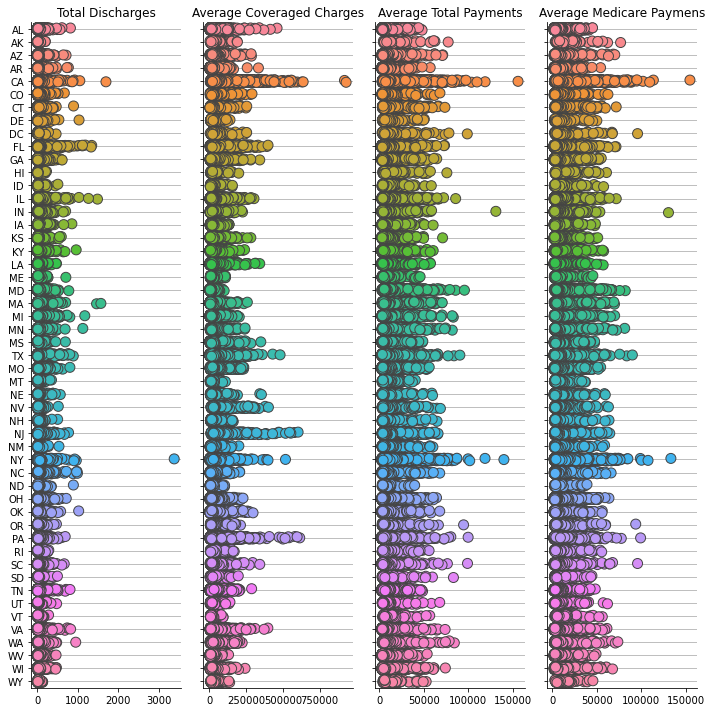

In [13]:
# Make the PairGrid
fig = plt.figure(figsize=(16,10))
g = sns.PairGrid(payment_data,
                 x_vars=['Total Discharges', 'Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments'], 
                 y_vars=["Provider State"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", linewidth=1)

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Total Discharges", "Average Coveraged Charges", "Average Total Payments",
          "Average Medicare Paymens"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

### Visualization by regions

<Figure size 1152x720 with 0 Axes>

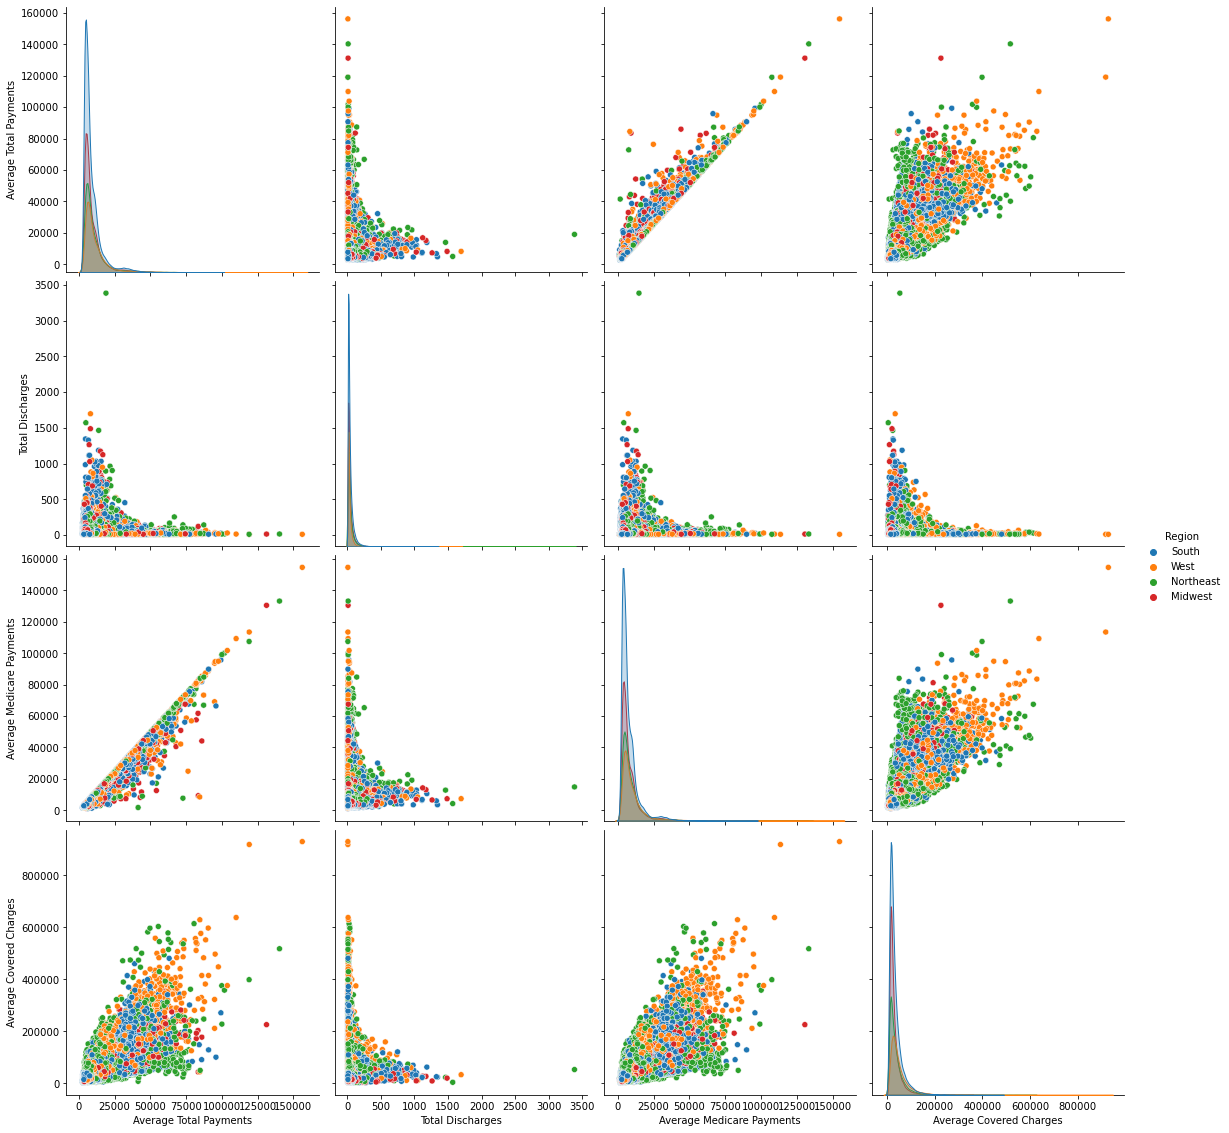

In [14]:
fig = plt.figure(figsize=(16,10))
sns.pairplot(payment_data[['Region','Average Total Payments',
                            'Total Discharges','Average Medicare Payments','Average Covered Charges']], hue= 'Region',height = 4)

### Feature Correlation

In [15]:
stats_df = pd.DataFrame(payment_data, columns=['Average Total Payments',
                            'Total Discharges','Average Medicare Payments','Average Covered Charges'])

<AxesSubplot:>

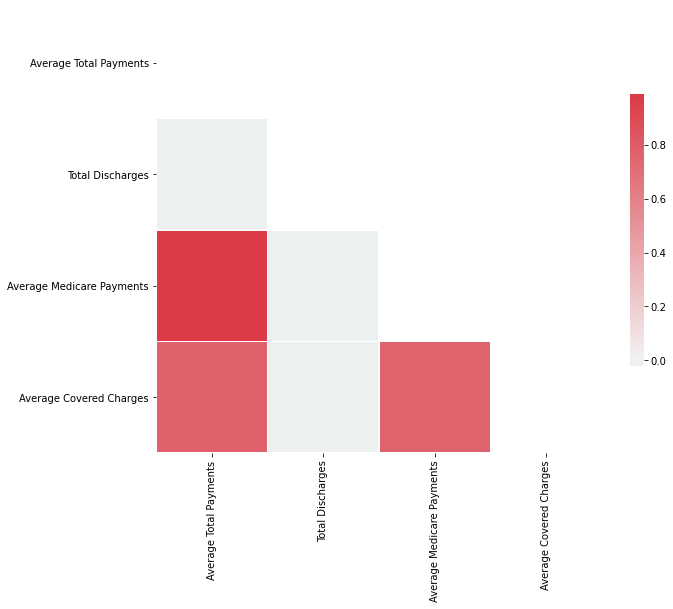

In [16]:
x = stats_df
corr = x.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The average medicare payments and average covered charges are highly correlated to each other. Furthermore, the average medicare payments are also highly correlated with the average total payments.   

### Common Procedures

<AxesSubplot:xlabel='count', ylabel='DRG Definition'>

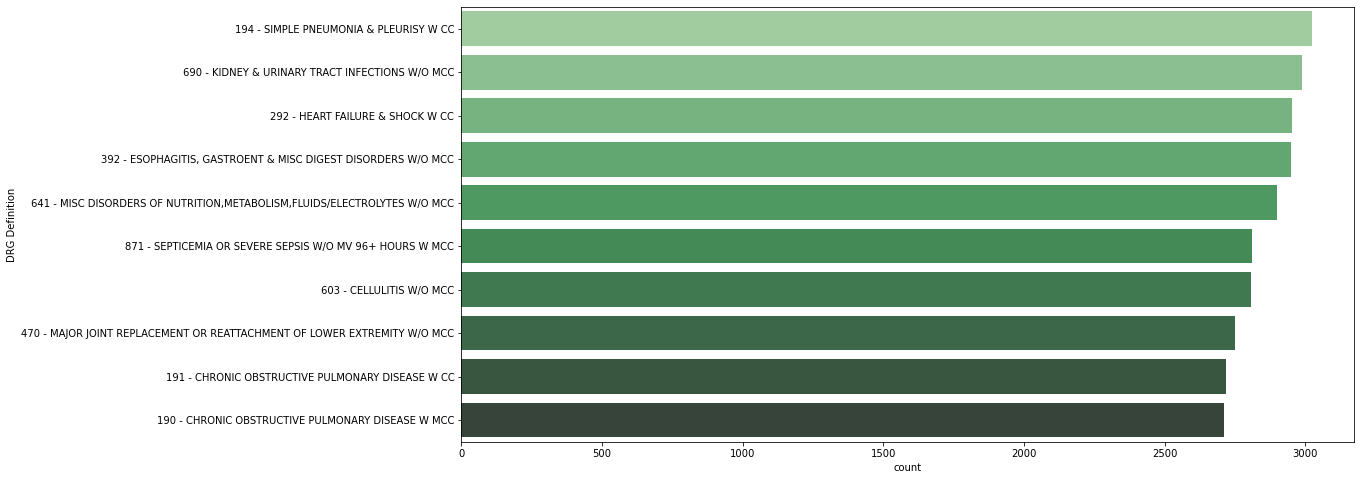

In [17]:
fig = plt.figure(figsize=(16,8))
common_drg = payment_data.groupby('DRG Definition').count()['Provider Id'].sort_values(ascending=False)
top_10 = common_drg[:10]
sns.countplot(y='DRG Definition', data=payment_data, palette="Greens_d",
              order=pd.value_counts(payment_data['DRG Definition']).iloc[:10].index)

### Features Engineering 

#### 1:  Patient Average by Provider ID

This feature will provide an estimation of the average amount charges/payment by each provider.

In [18]:
# gorup by id 
patient_avg_id = payment_data.groupby('Provider Id').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]
patient_avg_id.head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
Provider Id,,,,
10001,58.750000,35247.028152,8749.025109,7678.214348
10005,28.959184,16451.092041,6812.131224,5793.631429
10006,45.360465,36942.357442,8197.237907,7145.959535
10007,27.409091,12079.536818,4860.829091,4047.025455
10008,17.888889,16148.752222,5898.136667,4963.547778


**Conclusion**: This feature shows the average charge/payment of each provider which can be used as a baseline when there is any unsual amount. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies.

#### 2: Patient Average by State

This feature will provide an estimation of the average amount charges/payment in each state.

In [19]:
patient_avg_state = payment_data.groupby('Provider State').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]
patient_avg_state.head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
Provider State,,,,
AK,26.588745,40348.743333,14572.391732,12958.969437
AL,39.258322,31316.462074,7568.232149,6418.007120
AR,41.978229,26174.526246,8019.248805,6919.720832
AZ,36.690284,41200.063020,10154.528211,8825.717240
CA,36.357854,67508.616536,12629.668472,11494.381678


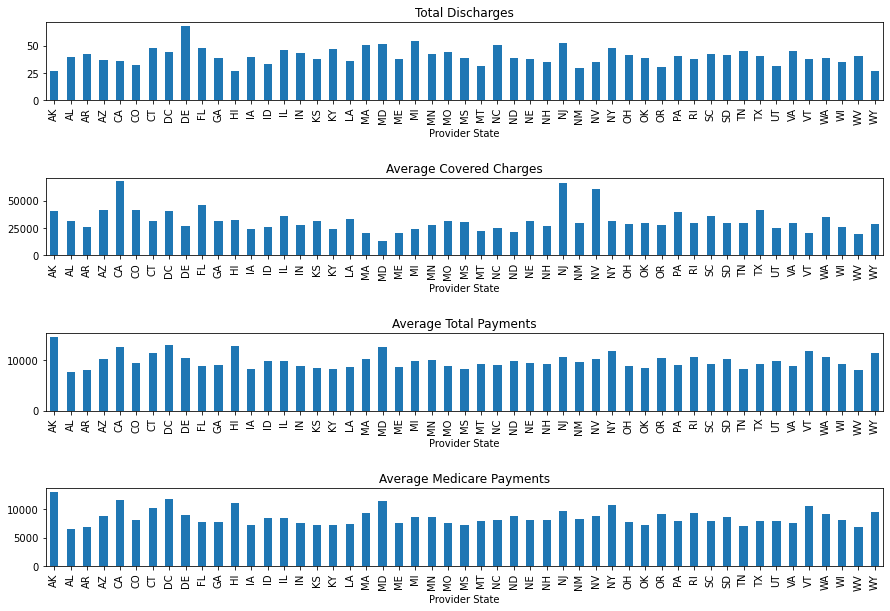

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(15,10))
plt.subplots_adjust(hspace=1)
for i, ax in enumerate(axes.flatten()):
    patient_avg_state[patient_avg_state.columns[i]].plot(kind='bar',ax=ax)
    ax.set_title(patient_avg_state.columns[i])

**Conclusion**: This feature will provide an estimation of the average amount charges/payment in each state which can be used to compare between states and treated as a baseline when there is any unsual amount. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies. 

#### 3: Patient Average by Region
This feature displays the average amount charges/payment in each region

In [21]:
patient_avg_reg = payment_data.groupby('Region').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]

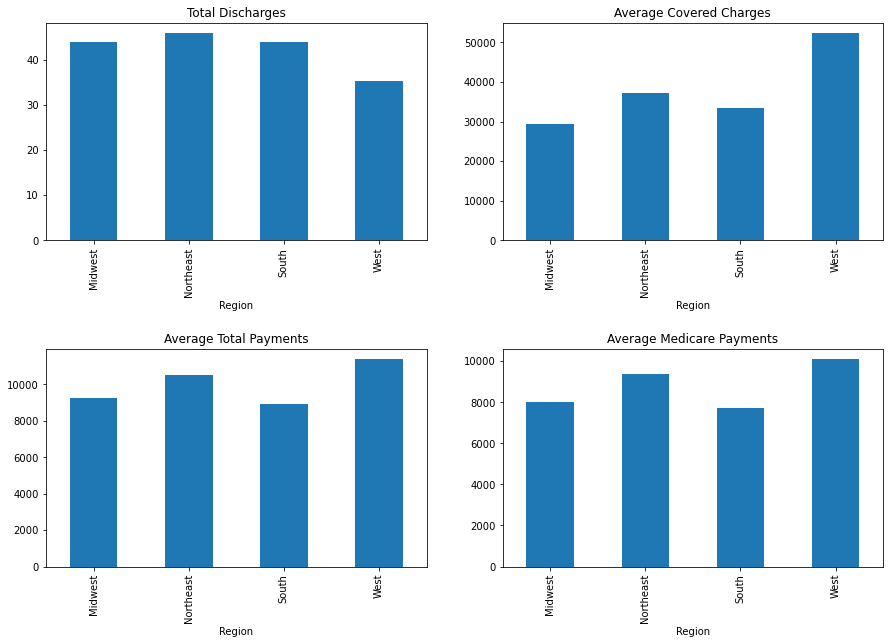

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flatten()):
    patient_avg_reg[patient_avg_reg.columns[i]].plot(kind='bar',ax=ax)
    ax.set_title(patient_avg_reg.columns[i])

**Conclusion**: This feature will provide an estimation of the average amount charges/payment in each region which can be used to compare between them and treated as a baseline when there is any unsual amount in each region. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies.

#### 4: Average out of pocket by provider name
This feature is the amount that patient pay by different provider. It gives us an idea which provider has the greatest charges.

In [23]:
payment_data['Ave Out of Pocket Payment'] = payment_data['Average Total Payments'] - payment_data['Average Medicare Payments']

In [24]:
oop_pro= payment_data[['Provider Name', 'Ave Out of Pocket Payment']].groupby(by='Provider Name').agg('mean')
oop_pro = oop_pro.sort_values(('Ave Out of Pocket Payment'), ascending=False)
oop_pro.head()

,Ave Out of Pocket Payment
Provider Name,
BAYLOR SURGICAL HOSPITAL AT FORT WORTH,14853.560000
CANCER TREATMENT CENTERS OF AMERICA,9613.663333
USMD HOSPITAL AT FORT WORTH LP,9169.745000
IRVING COPPELL SURGICAL HOSPITAL LLP,8728.920000
UVA HEALTH SCIENCES CENTER,8715.730000


Text(0.5, 0, 'Ave OoP per discharge')

<Figure size 2160x1440 with 0 Axes>

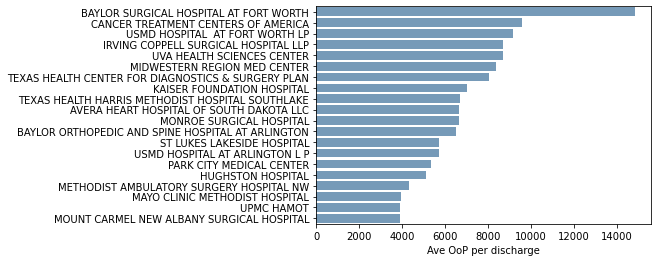

In [25]:
%%capture --no-stdout --no-display output 
#Stop warning from showing

# Top 20 out of pocket per provider

a =  oop_pro[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP per discharge")

**Conclusion**: Out of pocket is an important indicator for any hospital bill. This feature helps to define the mean of average out of pocket payment in each provider and can be used as a baseline to compare when any out of pocket charges occur.

#### 5: Out of pocket by procedures
This feature is the amount that patient pay by different procedures. It gives us an estimate amount for different procedures

In [26]:
oop_drg= payment_data[['DRG Definition', 'Ave Out of Pocket Payment']].groupby(by='DRG Definition').agg('mean')
oop_drg = oop_drg.sort_values(('Ave Out of Pocket Payment'), ascending=False)
oop_drg.head()

,Ave Out of Pocket Payment
DRG Definition,
460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,3735.070150
473 - CERVICAL SPINAL FUSION W/O CC/MCC,2594.714232
247 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC,2582.521719
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,2559.372528
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC,2497.221490


Text(0.5, 0, 'Ave OoP by Procedure')

<Figure size 2160x1440 with 0 Axes>

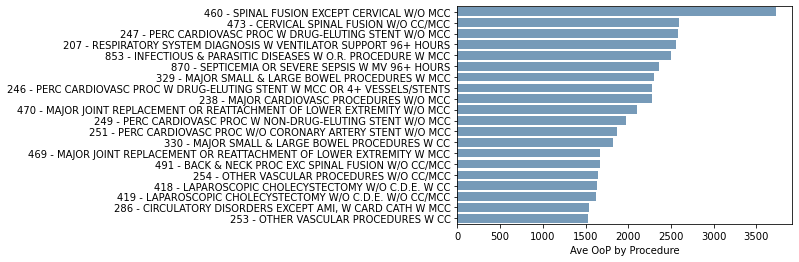

In [27]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 out of pocket by procedure
a =  oop_drg[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP by Procedure")

**Conclusion**: This feature helps to define the mean of average out of pocket payment in each procedures and can be used as a baseline to detect anomalies.

#### 6: Ave out of pocket per discharge

This feature shows the average amount of out of pocket per discharge for different procedures. If there are a high amount of charge occuring, they would be captured to possibily be investigated if needed.

In [28]:
payment_data['Ave OoP per discharge'] = payment_data['Ave Out of Pocket Payment']/payment_data['Total Discharges']

In [29]:
oop_dis= payment_data[['DRG Definition', 'Ave OoP per discharge']].groupby(by='DRG Definition').agg('mean')
oop_dis = oop_dis.sort_values(('Ave OoP per discharge'), ascending=False)
oop_dis.head()

,Ave OoP per discharge
DRG Definition,
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,136.913806
460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,128.522544
473 - CERVICAL SPINAL FUSION W/O CC/MCC,126.851226
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,121.497520
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,113.064950


Text(0.5, 0, 'Ave OoP per discharge')

<Figure size 2160x1440 with 0 Axes>

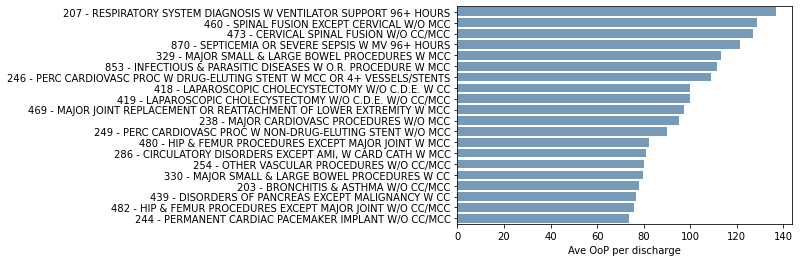

In [30]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 out of pocket per discharge
a =  oop_dis[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP per discharge")

**Conclusion**: This feature helps to define the mean of average out of pocket payment per discharge for each procedure and can be used as a baseline to detect anomaly. If a discharge pay a big difference amount from the mean for specific procedure, it would be noticable

#### 7: Percent of payment covered
This feature displays the proportion of the total payment compared to covered charge.

In [31]:
payment_data['Percent of Payment Covered'] = round((payment_data['Average Total Payments'] / 
                                                    payment_data['Average Covered Charges'])*100,2)
payment_data['Percent of Payment Covered'].head()

0    17.53
1    38.25
2    14.47
3    38.70
4    17.89
Name: Percent of Payment Covered, dtype: float64

In [32]:
pc_per= payment_data[['DRG Definition', 'Percent of Payment Covered']].groupby(by='DRG Definition').agg('mean')
pc_per = pc_per.sort_values(('Percent of Payment Covered'), ascending=False)
pc_per.head()

,Percent of Payment Covered
DRG Definition,
885 - PSYCHOSES,44.798483
603 - CELLULITIS W/O MCC,38.141585
897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REHABILITATION THERAPY W/O MCC,37.399592
292 - HEART FAILURE & SHOCK W CC,37.206478
871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC,37.103869


Text(0.5, 0, 'Percent of Payment Covered')

<Figure size 2160x1440 with 0 Axes>

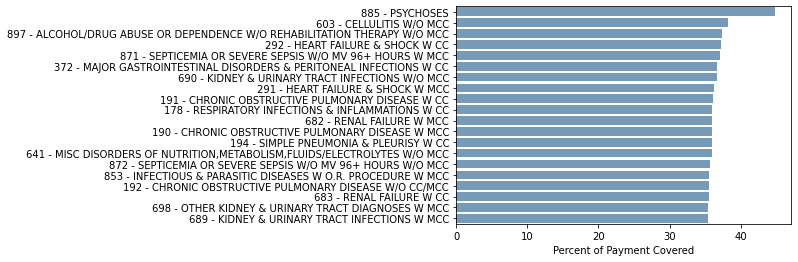

In [33]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 highest percent of payment covered
a =  pc_per[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Percent of Payment Covered")

**Conclusion**: This feature helps to define the percent of payment covered and can be used as a baseline to detect anomaly. If an unsual percentage of payment for a procedure occurs, it would be noticable.

#### 8: Medicare coverage ratio

This feature calculates the proportion covered by medicare for different procedures

In [34]:
payment_data['Medicare Coverage Ratio'] = (payment_data['Average Medicare Payments'] / payment_data['Average Total Payments'])

In [35]:
med_cv = payment_data[['DRG Definition', 'Medicare Coverage Ratio']].groupby(by='DRG Definition').agg('mean')
med_cv = med_cv.sort_values(('Medicare Coverage Ratio'), ascending=True)
med_cv.head()

,Medicare Coverage Ratio
DRG Definition,
310 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS W/O CC/MCC,0.717772
203 - BRONCHITIS & ASTHMA W/O CC/MCC,0.719805
313 - CHEST PAIN,0.727650
390 - G.I. OBSTRUCTION W/O CC/MCC,0.732743
149 - DYSEQUILIBRIUM,0.742108


Text(0.5, 0, 'Medicare Coverage Ratio')

<Figure size 1440x1440 with 0 Axes>

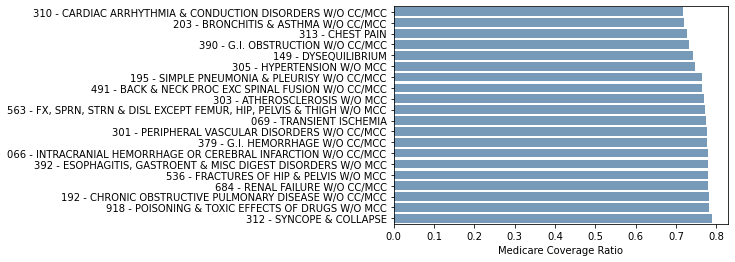

In [36]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 highest medicare covered
a =  med_cv[:20]
plt.figure(figsize=(20,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Medicare Coverage Ratio")

**Conclusion**: This feature helps to define the percent of medicare coverage for each procedure and can be used as a baseline to detect anomaly. If an unsual percentage of medicare charges for a procedure occurs, it would be noticable.

#### 9: Medicare coverage ratio by state
This feature displays the average percentage covered by medicare in each state

In [37]:
med_cv_state = payment_data[['Provider State', 'Medicare Coverage Ratio']].groupby(by='Provider State').agg('mean')
med_cv_state = med_cv_state.sort_values(('Medicare Coverage Ratio'), ascending=False)
med_cv_state.head()

,Medicare Coverage Ratio
Provider State,
MD,0.888943
CA,0.885084
DC,0.884320
VT,0.874861
MA,0.872525


Text(0.5, 0, 'Medicare Coverage Ratio')

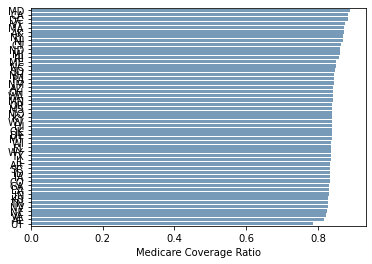

In [38]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

fig,ax= plt.subplots()
fig = sns.barplot(med_cv_state.iloc[:,0],med_cv_state.index,color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Medicare Coverage Ratio")

**Conclusion**: This feature helps to define the percent of medicare coverage in each state and can be used as a baseline to detect anomalies. If an unsual percentage of medicare happens, it would be noticable

###  Z-score 
Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls. For example, a Z-score of 2 indicates that an observation is two standard deviations above the average while a Z-score of -2 signifies it is two standard deviations below the mean. A Z-score of zero represents a value that equals the mean.

An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.


#### 10: Z-score Average Total Payment 
This feature calculates the z-score for average total payment

In [39]:
payment_data['Z-score Average Total Payments'] = stats.zscore(payment_data['Average Total Payments'])

In [40]:
payment_data['Z-score Average Total Payments'].max()

19.10736911457284

**Conclusion**: An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.This feature helps to detect any outlier in total payments. The example above shows that there is a z-score of 19.10 in the average total payment which needs to be investigated.

#### 11: Z-score Average Medicare Payments	
This feature calculates the z-score for average medicare payment

In [41]:
payment_data['Z-score Average Medicare Payments'] = stats.zscore(payment_data['Average Medicare Payments'])

In [42]:
payment_data['Z-score Average Medicare Payments'].max()

19.99143875873488

**Conclusion**: An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.This feature helps to detect any outlier in medicare payments. The example above shows that there is a z-score of 19.99 in the average medicare payment which need to be investigated.

#### 12: Average Covered Charges by Procedures
This feature calculates the average cost and number of cases of each procedure

In [43]:
ave_cv = payment_data[['DRG Definition', 'Average Covered Charges']].groupby(by='DRG Definition').agg(['mean','count'])
ave_cv = ave_cv.sort_values(('Average Covered Charges',  'mean'), ascending=False)
ave_cv.head()

Average Covered Charges  \
                                                                      mean   
DRG Definition                                                               
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS             163227.331725   
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR...           143428.051066   
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PR...           139186.350937   
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC             135330.939966   
246 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT...            96348.806707   

                                                          
                                                   count  
DRG Definition                                            
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS     939  
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR...  1163  
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PR...  1376  
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC    1476  
246 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT...   917

In [44]:
# Top 10 highest Average Medicare Payments
a = ave_cv[:10]

<Figure size 1080x1080 with 0 Axes>

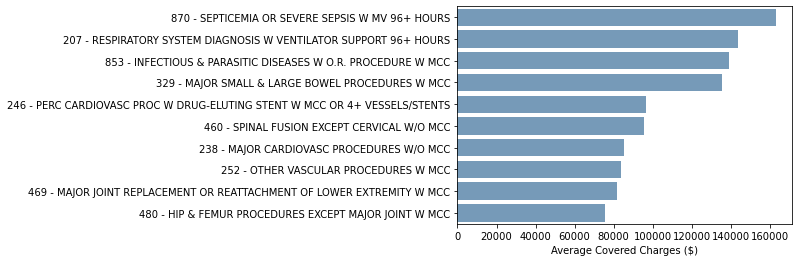

<Figure size 1080x1080 with 0 Axes>

In [45]:
%%capture --no-stdout --no-display output
# prevent warning message from showing
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Average Covered Charges ($)")
plt.figure(figsize=(15,15))

**Conclusion**: This features provides the insights of hospital bill for different procedures. From that, we could detect any unsual charge for specific procedure.

#### 12: Common Procedures by Region
This feature calculates the total cases of all procedures in each region

In [46]:
common_drug =  payment_data[['Region', 'DRG Definition']].groupby(by=['Region','DRG Definition']).agg({'DRG Definition': 'count'})

In [47]:
common_drug[:20]

DRG Definition
Region  DRG Definition                                                    
Midwest 039 - EXTRACRANIAL PROCEDURES W/O CC/MCC                       295
        057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O...             292
        064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             396
        065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             548
        066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             438
        069 - TRANSIENT ISCHEMIA                                       468
        074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC             245
        101 - SEIZURES W/O MCC                                         374
        149 - DYSEQUILIBRIUM                                           273
        176 - PULMONARY EMBOLISM W/O MCC                               373
        177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC             443
        178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC              453
        189 - PULMONARY EDEMA & RESPIRATORY FAILURE                    515
        190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC              637
        191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC               643
        192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/O...             621
        193 - SIMPLE PNEUMONIA & PLEURISY W MCC                        618
        194 - SIMPLE PNEUMONIA & PLEURISY W CC                         711
        195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC                   605
        202 - BRONCHITIS & ASTHMA W CC/MCC                             298

**Conclusion**: This feature can be used to identify non-common procedures and common procedures in each region, thus giving us an idea of what procedures are most common in each region. Therefore, we would be able to take closer look to different price point by provider for common procedures and  non-common procedures in order to detect fraud.

#### 13: Differences in Average Total Payment
This feature is the differences between maximum and minimum payments for each procedure

In [48]:
differences = payment_data[['DRG Definition','Average Total Payments']].groupby(by='DRG Definition').agg(['max','min'])
differences['Difference'] = differences[('Average Total Payments','max')] - differences[('Average Total Payments','min')]
differences = differences[:20].sort_values(by='Difference',ascending=False)
# the results were limited to the first 20 values, but can be changed to include as many or as little as needed by adjusting the range

<Figure size 1080x1080 with 0 Axes>

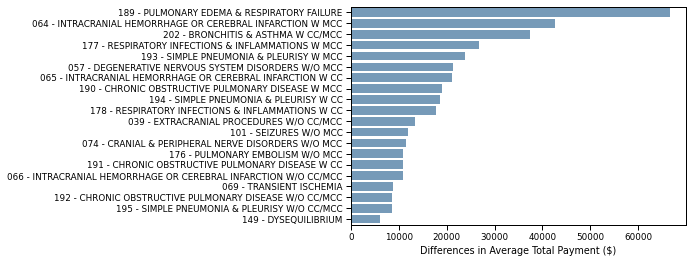

<Figure size 1080x1080 with 0 Axes>

In [49]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

sns.set_context("paper")
ax = sns.barplot(differences["Difference"],differences.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Differences in Average Total Payment ($)")
plt.figure(figsize=(15,15))

**Conclusion**: This feature helps to identify the difference in payment for the same procedure. If the difference is high for a procedure, it means that the payment varies largely between different states or different providers. Thus, we need to investigate further for these procedures. 

### Part 2: Data Preparation

Prepairing the dataset for modeling:

    - Drop irrelevant variables
    - Standardization of Numerical / Float variables

#### Payment data contains 19 mixed features of numerical and categorical columns. 

In [50]:
payment_data = payment_data.drop(columns = ['Provider Id'])
features = payment_data

In [51]:
%%capture --no-stdout --no-display output
features = features.merge(differences, on = "DRG Definition", how = "left")

In [52]:
# dtop Ave max and min here and keep difference
features.head()

,DRG Definition,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,...,Region,Ave Out of Pocket Payment,Ave OoP per discharge,Percent of Payment Covered,Medicare Coverage Ratio,Z-score Average Total Payments,Z-score Average Medicare Payments,"(Average Total Payments, max)","(Average Total Payments, min)","(Difference, )"
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,...,South,1013.51,11.137473,17.53,0.824568,-0.512776,-0.510403,18420.56,4968.0,13452.56
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,...,South,810.86,57.918571,38.25,0.859896,-0.511428,-0.481265,18420.56,4968.0,13452.56
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,...,South,981.16,40.881667,14.47,0.819472,-0.557435,-0.552805,18420.56,4968.0,13452.56
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,...,South,1288.40,51.536000,38.70,0.762181,-0.559703,-0.597218,18420.56,4968.0,13452.56
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,...,South,806.89,44.827222,17.89,0.857398,-0.528290,-0.498403,18420.56,4968.0,13452.56


In [53]:
features.rename(columns={('Average Total Payments', 'max'):'max',
                         ('Average Total Payments', 'min'): 'min',
                         ('Difference', ''): 'Differences'
                        }, inplace=True)

In [54]:
features.drop(
    ['min', 'max'],
    axis=1, inplace=True)

In [55]:
# not doing this one because the df only has the medicare coverage ratio columns, this one provides information 
## of coverage ratio by state.
features = features.merge(med_cv_state, on = "Provider State", how = "left")

In [56]:
features = features.merge(patient_avg_state, on = "Provider State", how= "left")

In [57]:
# Rename the last 4 columns as Ave by state
features.head()

,DRG Definition,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges_x,Average Covered Charges_x,Average Total Payments_x,...,Percent of Payment Covered,Medicare Coverage Ratio_x,Z-score Average Total Payments,Z-score Average Medicare Payments,Differences,Medicare Coverage Ratio_y,Total Discharges_y,Average Covered Charges_y,Average Total Payments_y,Average Medicare Payments_y
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,...,17.53,0.824568,-0.512776,-0.510403,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,...,38.25,0.859896,-0.511428,-0.481265,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,...,14.47,0.819472,-0.557435,-0.552805,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,...,38.70,0.762181,-0.559703,-0.597218,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,...,17.89,0.857398,-0.528290,-0.498403,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712


In [58]:
features = features.rename(columns={"Total Discharges_x": "Total_Discharges", 
                                   "Average Covered Charges_x": "Ave_Covered_Charges",
                                   "Average Total Payments_x": "Ave_Total_Payments",
                                   "Average Medicare Payments_x":"Aver_Medicare_Payments",
                                   "Ave Out of Pocket Payment":"Ave_OOP",
                                   "Percent of Payment Covered" : "Prop_payment_covered",
                                   "Medicare Coverage Ratio_x":"Medicare_Coverage_Ratio",
                                   "Z-score Average Total Payments": "Zscore_ave_total_payment",
                                   "Z-score Average Medicare Payments": "Zscore_ave_medicare_payment",
                                    "Medicare Coverage Ratio_y": "Medicare_coverage_ratio_bystate",
                                   "Total Discharges_y":"Mean_Total_Discharge_bystate", 
                                   "Average Covered Charges_y":"Mean_Ave_Covered_bystate",
                                  "Average Total Payments_y":"Mean_Ave_Total_Payment_bystate",
                                  "Average Medicare Payments_y":"Mean_Ave_Medicare_bystate"})

#### *Note*

KNN and PCA only work well with numerical columns and there are more than 50 unique values in categorical columns like DRG definition, Provider ID, provider name, provider city, provider state, provider zipcode, hospital referral regions. Therefore, one hot encoder doesn't make significant support to clustering method. Additionally, using one hot encoding creates many different new binary features which does not apply to K-mean clustering accurately.  Therefore, all categorical columns are decided to drop.

In [59]:
categorical_col = features.loc[:, features.dtypes == np.object]
a = categorical_col.columns
features = features.drop(columns = a)

In [60]:
features.columns

Index(['Total_Discharges', 'Ave_Covered_Charges', 'Ave_Total_Payments',
       'Aver_Medicare_Payments', 'Ave_OOP', 'Ave OoP per discharge',
       'Prop_payment_covered', 'Medicare_Coverage_Ratio',
       'Zscore_ave_total_payment', 'Zscore_ave_medicare_payment',
       'Differences', 'Medicare_coverage_ratio_bystate',
       'Mean_Total_Discharge_bystate', 'Mean_Ave_Covered_bystate',
       'Mean_Ave_Total_Payment_bystate', 'Mean_Ave_Medicare_bystate'],
      dtype='object')

In [61]:
features.isnull().sum()

Total_Discharges                        0
Ave_Covered_Charges                     0
Ave_Total_Payments                      0
Aver_Medicare_Payments                  0
Ave_OOP                                 0
Ave OoP per discharge                   0
Prop_payment_covered                    0
Medicare_Coverage_Ratio                 0
Zscore_ave_total_payment                0
Zscore_ave_medicare_payment             0
Differences                        124528
Medicare_coverage_ratio_bystate         0
Mean_Total_Discharge_bystate            0
Mean_Ave_Covered_bystate                0
Mean_Ave_Total_Payment_bystate          0
Mean_Ave_Medicare_bystate               0
dtype: int64

With a large amount of missing values in differences column, it does not have significant impact to the model after imputing missing values

In [62]:
features['Differences'].isnull().sum()/len(features)

0.7636709287707356

In [63]:
features = features.drop(columns = ['Differences'])

### Correlation

<AxesSubplot:>

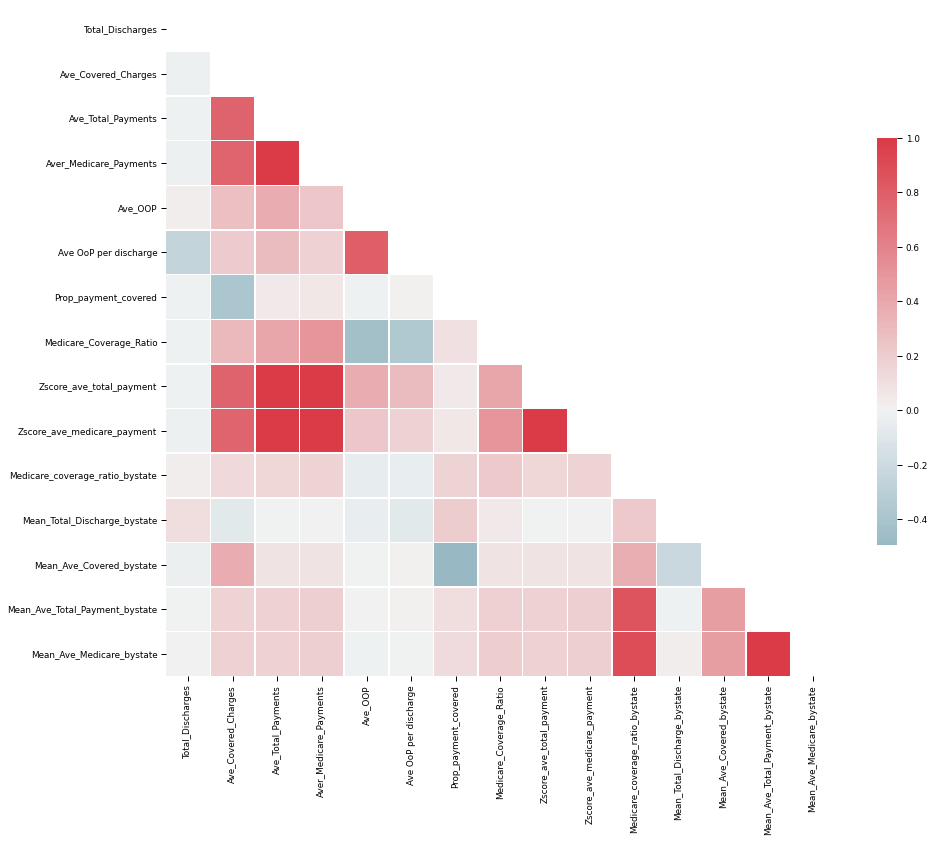

In [64]:
corr =features.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In general, feautures that are too correlated do not improve model efficiency and also affect the performance of linear regression and random forest models, making the learning algorithms slower to create and train. Therefore, I removed highly correlated features to prevent multicollinearity trhough the following function:

In [65]:
# Function to remove columns with high correlation value
def correlation(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

In [66]:
features = correlation(features, 0.9)

In [67]:
features.isna().sum()

Total_Discharges                   0
Ave_Covered_Charges                0
Ave_Total_Payments                 0
Ave_OOP                            0
Ave OoP per discharge              0
Prop_payment_covered               0
Medicare_Coverage_Ratio            0
Medicare_coverage_ratio_bystate    0
Mean_Total_Discharge_bystate       0
Mean_Ave_Covered_bystate           0
Mean_Ave_Total_Payment_bystate     0
dtype: int64

## Part 2: Unsupervised Learning for Anomalies Detection

### Principal Component Analysis (PCA) 

PCA is a linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The PCA-Based Anomaly Detection module solves the problem by analyzing available features to determine what constitutes a "normal" class, and applying distance metrics to identify cases that represent anomalies. 

Split dataset into train and test before standardizing the data

In [68]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test = tts(features, test_size=0.30)
from pyod.utils.utility import standardizer
# Standardize data
X_train, X_test= standardizer(X_train, X_test)

In [70]:
pca = PCA()
pca_fit = pca.fit(X_train)  

In [71]:
# For the predictions of the training data:
y_train_scores = pca.decision_scores_

In [72]:
# Now we have the trained PCA model, let's apply to the test data to get the predictions
y_test_pred = pca.predict(X_test) # outlier labels (0 or 1)
# Because it is '0' and '1', we can run a count statistic. There are 44070 '1's and 456 '4850's. 
#The number of anomalies is approximately ten percent, as we have generated before:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))
#{0: 44070, 1: 4850}
# Generate the anomaly score using pca.decision_function:
y_test_scores = pca.decision_function(X_test)

By using the function, explained_variance_ratio, we can see that the variance score for all components under the PCA model.

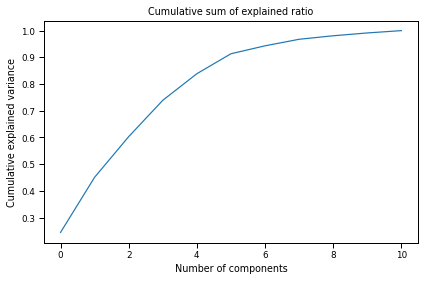

In [73]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative sum of explained ratio')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.tight_layout()
plt.show()

In [74]:
np.cumsum(pca.explained_variance_ratio_)

array([0.24448861, 0.45108973, 0.6031976 , 0.73915498, 0.83877332,
       0.91347225, 0.9431591 , 0.96761278, 0.9807727 , 0.99132136,
       1.        ])

The PCA indicates that 99.13% of the of the variables can be captured by 10 components.Thus, I have the option to choose 10 as it gives the principal components an incremental value of 99.13%.

However, as discussed in class, it is suggested that to keep the same number of components. Therefore, I would keep all 11 features here as recommended by the professor.

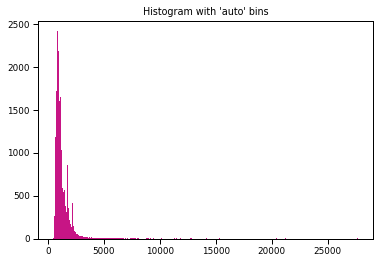

In [75]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto', color='mediumvioletred', lw=0)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

Create a dataframe for grouping data points using the results from y_test_scores. After generating different scores ranges, 
the code below make 3 different clusters where one cluster has about 6% of the data points.  

In [76]:
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<700, 2,
                              (np.where(df_test['score']<1500, 0, 1)))
df_test['cluster'].value_counts()

0    34794
1    11113
2     3013
Name: cluster, dtype: int64

In [77]:
df_test['score'].describe()

count    48920.000000
mean      1244.023329
std        694.477713
min        476.225151
25%        862.061369
50%       1055.764673
75%       1438.135050
max      27662.721271
Name: score, dtype: float64

In [78]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,score
cluster,,,,,,,,,,,,
0,-0.072755,-0.208975,-0.224965,-0.142122,-0.117929,-0.043599,-0.037450,-0.256868,0.055712,-0.226813,-0.298481,1012.957203
1,0.319755,0.721435,0.767749,0.515540,0.452200,0.203777,0.041871,0.901751,-0.123544,0.723400,1.007677,2128.565872
2,-0.173436,-0.253020,-0.241316,-0.163855,-0.190221,-0.186745,0.217144,-0.375160,-0.150630,-0.022109,-0.289592,649.862520


<AxesSubplot:xlabel='cluster'>

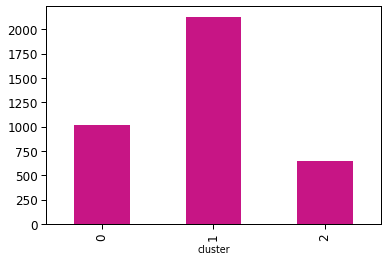

In [79]:
df_test.groupby('cluster')['score'].mean().plot.bar(fontsize=12, color='mediumvioletred')

From the table and chart above, the average anomaly score in Cluster 2 is much lower than that of Cluster 0 and cluster 1. The summary statistics also show dramatic differences between them in every feature. Additionally, cluster 2 only takes about 6% of the dataset (3013 data points). Therefore, I believe that the data points in Cluster 2 could be anomalous and deserve further inspection.

By aggregating multiple models, the chance of overfitting is greatly reduced and the prediction accuracy will be improved.The PyOD module offers four methods to aggregate the outcome, which are Average, Maximum of Maximum (MOM),Average of Maximum (AOM), Maximum of Average (MOA). Normally, we can choose one method and aggregate the outcome. However, I am going to use the Average and Maximun of maximum (MOM) methods today, so that we can see the differences and benefits in different approaches with the given dataset. 

#### Average

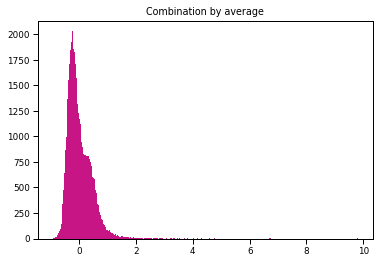

In [81]:
# Combination by average
y_by_average = average(X_test)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto',color='mediumvioletred', lw=0) # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

Create a dataframe for grouping data points using the results from X_test. After generating different scores ranges, the code below make 3 different clusters where one cluster has about 6% of the data points.

In [82]:
# Combination by mom
y_by_maximization = maximization(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']< -0.1, 0,
                                            (np.where(df_test['y_by_average_score']< -0, 2, 1)))
df_test['y_by_average_cluster'].value_counts()

0    24416
1    19968
2     4536
Name: y_by_average_cluster, dtype: int64

In [83]:
df_test['y_by_average_score'].describe()

count    48920.000000
mean         0.002208
std          0.422596
min         -0.919141
25%         -0.293772
50%         -0.099129
75%          0.242968
max          9.799379
Name: y_by_average_score, dtype: float64

In [84]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,score,cluster,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,
0,-0.152548,-0.370799,-0.457816,-0.156949,-0.088994,-0.140696,-0.346260,-0.585800,-0.298915,-0.258783,-0.557212,960.287413,0.227269,-0.310434
1,0.201765,0.468644,0.569591,0.227712,0.148938,0.176918,0.355280,0.783578,0.339706,0.347302,0.747008,1653.371704,0.516226,0.396949
2,0.043027,-0.070675,-0.048074,-0.093554,-0.099686,0.019278,0.259394,-0.306492,0.138163,-0.118098,-0.302234,969.293995,0.282628,-0.052632


<AxesSubplot:xlabel='y_by_average_cluster'>

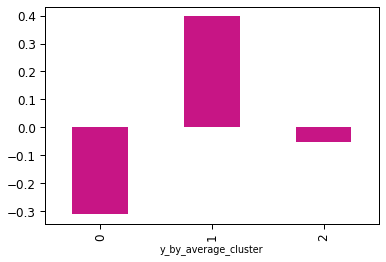

In [85]:
df_test.groupby('y_by_average_cluster')['y_by_average_score'].mean().plot.bar(fontsize=12, color='mediumvioletred')

The average anomaly score in Cluster 2 is very different from Cluster 0 and cluster 1. The summary statistics also show large differences between these clusters in every feature. Additionally, cluster 2 only takes approximately 10% of the dataset (4549 data points). Therefore, I believe that the data points in Cluster 2 could be anomalous and deserve further inspection.

#### Maximum of Maximum (MOM)

In [86]:
# Combination by mom
y_by_maximization = maximization(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

1    48121
0      799
Name: y_by_maximization_cluster, dtype: int64

When we use the Maximum of Maximum method, we get 799 data points that have an outlier scores higher than 0 with 2 clusters. While we used 3 clusters above, there was a clear delineation with just 2 clusters for this measure, so I reduced the number as performance did not improve with 3. Next, we use the following code to produce the summary statistics by cluster.

In [87]:
df_test['y_by_maximization_score'].describe()

count    48920.000000
mean         1.535629
std          1.547922
min         -0.316791
25%          0.617005
50%          1.179640
75%          2.152001
max         67.873187
Name: y_by_maximization_score, dtype: float64

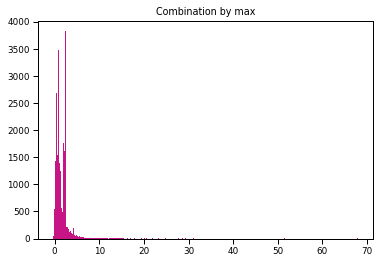

In [88]:
# Combination by mom
y_by_maximization = maximization(X_test)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto',color='mediumvioletred', lw=0)  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [89]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,score,cluster,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,
0,-0.288531,-0.501673,-0.684760,-0.250434,-0.225714,-0.472337,-0.670406,-0.641649,-0.642467,-0.463731,-0.787492,923.958567,0.133917,-0.511745,0.000000,-0.094860
1,0.015169,0.007995,0.010902,0.010195,0.010999,0.011685,0.007319,0.009685,0.012988,0.009379,0.011838,1249.337677,0.353941,0.010741,0.603479,1.562702


<AxesSubplot:xlabel='y_by_maximization_cluster'>

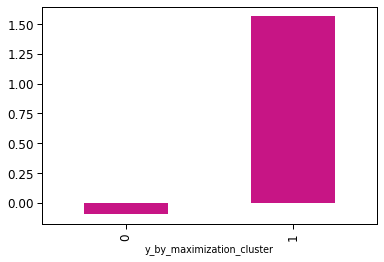

In [90]:
df_test.groupby('y_by_maximization_cluster')['y_by_maximization_score'].mean().plot.bar(fontsize=12, color='mediumvioletred')

By using MOM method, we can see that there are dramatic differences between cluster 0 and cluster 1 in the summary statistic table above. Furthermore, the average maximization score of cluster 0 is significantly lower than cluster 1. Therefore, I believe that the data points in Cluster 0 could be anomalous and deserves further inspection.

### K-nearest neighbor: KNN  Model:

KNN-based anomaly detection methods relies on neighbors search to decide whether a data point is an outlier. The method computes the distance of an observation called the Euclidean distance, which compares observations against each other. Thus, an isolated data point has a large distance to other observations and it can be seen as an outlier through KNN. 

Split train test datasets and standardize the data

In [91]:
from sklearn.model_selection import train_test_split as tts

X_train, X_test = tts(features, test_size=0.3)
from pyod.utils.utility import standardizer
# Standardize data
X_train, X_test= standardizer(X_train, X_test)

In [92]:
# train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)
# Outlier scores:
y_train_scores = clf.decision_scores_

In [93]:
# Now we have the trained K-NN model, let's apply to the test data to get the predictions
y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
# Because it is '0' and '1', we can run a count statistic. There are 44 '1's and 456 '0's. The number of anomalies is roughly ten percent, as we have generated before:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))
#{0: 456, 1: 44}
# And you can generate the anomaly score using clf.decision_function:
y_test_scores = clf.decision_function(X_test)

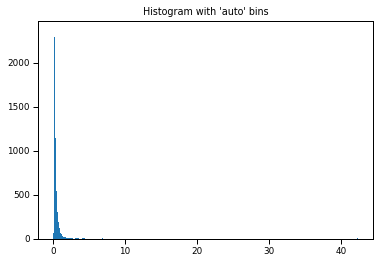

In [94]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto',lw=0)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

Create a dataframe for grouping clusters. 

In [95]:
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster'].value_counts()

0    46112
1     2808
Name: cluster, dtype: int64

In [96]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,score
cluster,,,,,,,,,,,,
0,-0.053490,-0.080232,-0.113099,-0.138047,-0.104031,-0.018746,0.034724,-0.001532,0.022909,0.006031,-0.012583,0.373883
1,0.858927,1.395625,1.882697,2.208307,1.711775,0.264079,-0.551027,-0.016674,-0.136797,-0.059699,0.150461,1.568175


<AxesSubplot:xlabel='cluster'>

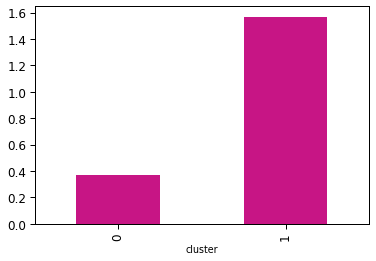

In [97]:
df_test.groupby('cluster')['score'].mean().plot.bar(fontsize=12, color='mediumvioletred')

The average anomaly score in Cluster 1 is much higher than Cluster 0. The summary statistics also show large differences between the two clusters in every feature. Additionally, cluster 1 only takes about 6% of the dataset (2808 data points). Therefore, I believe that the data points in Cluster 1 could be anomalous and deserve further inspection.

### Achieve Model Stability by Aggregating Multiple Models

This approach is to reduce the chance of overfitting and improve the prediction accuracy.

In [98]:
X_train, X_test = tts(features, test_size=0.3)
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 20 k-NN models.
n_clf = 20
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 
 120, 130, 140, 150, 160, 170, 180, 190, 200]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

From all four PyOD methods, I choose Average and Maximum of Maximum methods to find anomalous clusters. With different approaches, we will see a small change in total number of anomalous values. 

### Method 1: Average

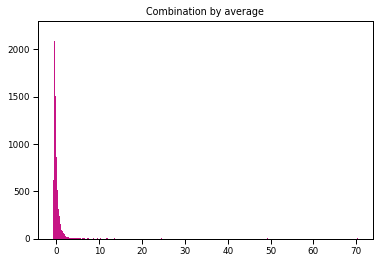

In [100]:
# Combination by average
y_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto',color='mediumvioletred', lw=0) # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

Create a dataframe for grouping data points using the results from y_test_scores. After generating different scores ranges, the code below make 3 different clusters where one cluster has about 6% of the data points.

In [101]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] =  np.where(df_test['y_by_average_score']< -0.1, 0,
                                            (np.where(df_test['y_by_average_score']< -0, 2, 1)))
df_test['y_by_average_cluster'].value_counts()

0    30219
1    15535
2     3166
Name: y_by_average_cluster, dtype: int64

In [102]:
df_test['y_by_average_score'].describe()

count    48920.000000
mean         0.001864
std          1.024943
min         -0.758232
25%         -0.432940
50%         -0.235889
75%          0.139228
max         70.302526
Name: y_by_average_score, dtype: float64

In [103]:
df_test.groupby('y_by_average_cluster').mean()

,Total_Discharges,Ave_Covered_Charges,Ave_Total_Payments,Ave_OOP,Ave OoP per discharge,Prop_payment_covered,Medicare_Coverage_Ratio,Medicare_coverage_ratio_bystate,Mean_Total_Discharge_bystate,Mean_Ave_Covered_bystate,Mean_Ave_Total_Payment_bystate,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,
0,33.162249,28040.104088,7293.289628,896.176893,37.152267,31.721087,0.855126,0.847397,43.099472,36983.937343,9700.512995,-0.390124
1,60.514837,53133.309223,14668.412225,1867.328584,76.289759,36.553877,0.830196,0.845619,42.263915,34973.442101,9773.504899,0.775300
2,46.185092,32417.838234,8903.654318,1072.961611,40.074716,34.901901,0.845802,0.843813,42.442675,33436.026414,9465.212670,-0.051783


<AxesSubplot:xlabel='y_by_average_cluster'>

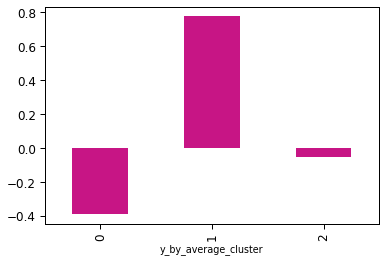

In [104]:
df_test.groupby('y_by_average_cluster')['y_by_average_score'].mean().plot.bar(fontsize=12, color='mediumvioletred')

The absolute score of y_by_average_score in Cluster 2 is significantly lower than the absolute score of Cluster 0 and cluster 1. The summary statistics also show large differences between the two clusters in every feature. Additionally, cluster 2 only takes about 6% of the dataset (3166 data points). Therefore, I believe that the data points in Cluster 2 could be anomalous and deserve further inspection.

### Method 2: The Maximum of Maximum (MoM)

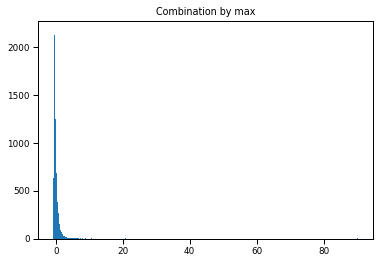

In [105]:
# Combination by mom
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto', lw=0)  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

Create a dataframe for grouping data points using the results from y_test_scores. After generating different scores ranges, the code below make 3 different clusters where one cluster has about 6% of the data points.

In [106]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] =  np.where(df_test['y_by_maximization_score']< -0.1, 0,
                                                 (np.where(df_test['y_by_maximization_score']<0, 2, 1)))
df_test['y_by_maximization_cluster'].value_counts()

0    27340
1    18081
2     3499
Name: y_by_maximization_cluster, dtype: int64

In [107]:
df_test.groupby('y_by_maximization_cluster').mean()

,Total_Discharges,Ave_Covered_Charges,Ave_Total_Payments,Ave_OOP,Ave OoP per discharge,Prop_payment_covered,Medicare_Coverage_Ratio,Medicare_coverage_ratio_bystate,Mean_Total_Discharge_bystate,Mean_Ave_Covered_bystate,Mean_Ave_Total_Payment_bystate,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,
0,32.376993,27778.831031,7166.175707,883.232781,36.933977,31.416214,0.855728,0.847885,43.203059,37377.232546,9733.059564,-0.415359,0.000000,-0.373306
1,58.424700,50232.169230,13857.820603,1756.494024,71.221979,36.306667,0.832438,0.845116,42.232634,34679.116796,9712.145539,0.657857,1.088048,0.829459
2,41.979423,30775.549534,8565.925862,1023.367494,39.212002,34.742295,0.848535,0.844235,42.465413,33684.434593,9497.259835,-0.127925,0.627036,-0.051398


<AxesSubplot:xlabel='y_by_maximization_cluster'>

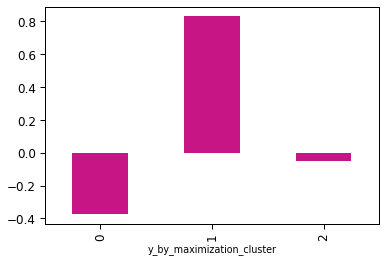

In [108]:
df_test.groupby('y_by_maximization_cluster')['y_by_maximization_score'].mean().plot.bar(fontsize=12, color='mediumvioletred')

The y_by_maximization_score in Cluster 2 is much lower than that of Cluster 0 and cluster 1. The summary statistics also show large differences between the two clusters in every feature. Additionally, cluster 2 only takes about 6% of the dataset (3499 data points). Therefore, I believe that the data points in Cluster 2 could be anomalous and deserve further inspection.

### Summary:

Overall, recorgnizing potentially frauds in heathcare is not an easy task. Each provider has a different population and price tag for their drug. By applying PCA and KNN methods, anomalous charges can be detected, avoiding fraud. With the given dataset, there are some takeaways from the report as follows:

    - PCA method:
        - With the anomaly score, there are 3 clusters created where one cluster contains about 6% of the data points. In this cluster, the summary statistic also shows that its average anomaly score is much lower than the other two clusters. 
        - With the Average method, there are also 3 clusters created where one cluster contains aproximately 10% of the data points. In this cluster, the summary statistic also shows that its average score is much lower than the other two.
        - With The Maximum of Maximum method, there are 2 clusters created where one cluster contains about 2% of the data points. In this cluster, the summary statistic also shows that its maximization score is significantly lower than the other cluster.
    - KNN method:
        - With the anomaly score, there are 2 clusters created where one cluster contains about 5% of the data points. In this cluster, the summary statistic also shows that its average anomaly score is much lower than the other two clusters. 
        - With the Average method, there are 3 clusters created where one cluster contains about 6% of the data points. In this cluster, the summary statistic also shows that its average anomaly score is much lower than the other two clusters. 
        - With The Maximum of Maximum method, there are 3 clusters created where one cluster contains about 6% of the data points. In this cluster, the summary statistic also shows that its average anomaly score is much lower than the other two clusters. 
        
**Conclusion:** Overall, both of the approaches provide insights to detect anomalies. In PCA, the MOM method defines 2 clusters where the statistics calculation shows a significant difference between them. However, the other approaches required smaller breakdowns with 3 clusters to notice the anomalous activities. In KNN, the anomaly score defined 2 clusters where the statistics calculation showed a significant difference between them. However, the other approaches required smaller breakdowns to 3 clusters to notice the anomalous activities. Therefore, it is essential to try different modelling and approaches from PyOD to compare the anomaly detection effectiveness.